# The P-Dispersion Problem: An Empirical Example

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

This tutorial extends the [Empirical examples](facloc-real-world.ipynb) notebook, specifically for the $p$-dispersion problem. A deeper dive into the $p$-dispersion problem can be found [here](p-dispersion.ipynb).
Also, this tutorial demonstrates the use of different solvers that [PULP](https://github.com/coin-or/pulp) supports.

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2025-04-07T13:52:41.571790-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import time
import warnings

import geopandas
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib_scalebar
import numpy
import pandas
import pulp
import shapely
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point

import spopt
from spopt.locate import PDispersion

%watermark -w
%watermark -iv

Watermark: 2.5.0

matplotlib         : 3.10.1
geopandas          : 1.0.1
shapely            : 2.1.0
pulp               : 2.8.0
spopt              : 0.6.2.dev3+g13ca45e
numpy              : 2.2.4
pandas             : 2.2.3
matplotlib_scalebar: 0.9.0



-------------------
We use 2 data files as input:

- `facility_points` represents the stores that are candidate facility sites
- `tract` is the polygon of census tract 205.

***Note*** that all other 'Real World Facility Location' demonstration notebooks utilize [this file](https://github.com/huanfachen/Open_source_location_cover_models/blob/master/Data/San_Francisco_store/SF_network_distance_candidateStore_16_censusTract_205_new.csv) which contains facility-client network distances that were calculated using the ArcGIS Network Analyst Extension. This notebook, solving for $P$-Dispersion, *does not* use this file or any network distances and instead relies solely on euclidean distance for solving the model.

All datasets are available online in this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store).

In [3]:
DIRPATH = "../spopt/tests/data/"

`facility_points` dataframe

In [4]:
facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
facility_points = facility_points.reset_index(drop=True)
facility_points

,OBJECTID,NAME,long,lat
0,1,Store_1,-122.510018,37.772364
1,2,Store_2,-122.488873,37.753764
2,3,Store_3,-122.464927,37.774727
3,4,Store_4,-122.473945,37.743164
4,5,Store_5,-122.449291,37.731545
5,6,Store_6,-122.491745,37.649309
6,7,Store_7,-122.483182,37.701109
7,8,Store_11,-122.433782,37.655364
8,9,Store_12,-122.438982,37.719236
9,10,Store_13,-122.440218,37.745382


`study_area` dataframe

In [5]:
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()
study_area

,geometry
0,"POLYGON ((-122.45299 37.63898, -122.45415 37.6..."


Plot `study_area`

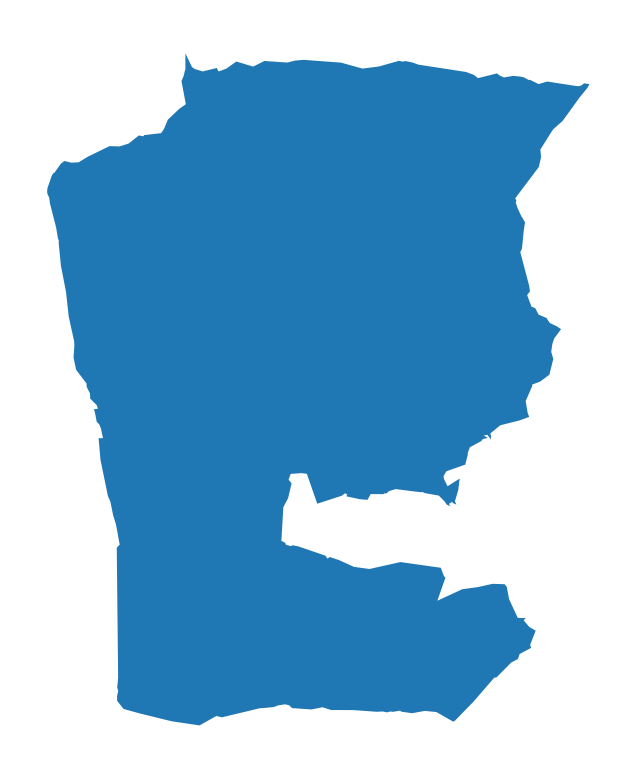

In [6]:
base = study_area.plot()
base.axis("off");

Create a geodataframe of the candidate facility sites.

In [7]:
process = lambda df: as_gdf(df).sort_values(by=["NAME"]).reset_index(drop=True)  # noqa: E731
as_gdf = lambda df: geopandas.GeoDataFrame(df, geometry=pnts(df))  # noqa: E731
pnts = lambda df: geopandas.points_from_xy(df.long, df.lat)  # noqa: E731

In [8]:
facility_points = process(facility_points)

Reproject the input spatial data.

In [9]:
for _df in [facility_points, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

Set parameter `P_FACILITIES` for the number for candidate facilities to include in the optimal selection set.

In [10]:
# number of candidate facilities in optimal solution
P_FACILITIES = 3

In [11]:
solver = pulp.PULP_CBC_CMD(msg=False)

-------------------------------------------------
## P-Dispersion

In [12]:
pdispersion = PDispersion.from_geodataframe(
    facility_points,
    "geometry",
    P_FACILITIES,
    distance_metric="euclidean",
    name="p-dispersion",
)
pdispersion = pdispersion.solve(solver)
pdispersion

In [13]:
n_fac_pnts = facility_points.shape[0]
pdispersion_obj = round(pdispersion.problem.objective.value(), 3)
print(
    "A maximized minimum inter-facility distance between any two sited candiate "
    f"facilities of {pdispersion_obj} meters is observed while siting "
    f"facilities at {P_FACILITIES} of the available {n_fac_pnts} locations."
)

A maximized minimum inter-facility distance between any two sited candiate facilities of 10164.495 meters is observed while siting facilities at 3 of the available 16 locations.


Define the decision variable names used for mapping later.

In [14]:
facility_points["dv"] = pdispersion.fac_vars
facility_points["dv"] = facility_points["dv"].map(
    lambda x: x.name.replace("_", "").replace("x", "y")
)
facility_points

,OBJECTID,NAME,long,lat,geometry,dv
0,1,Store_1,-122.510018,37.772364,POINT (42712.165 26483.898),y0
1,8,Store_11,-122.433782,37.655364,POINT (49431.133 13496.279),y1
2,9,Store_12,-122.438982,37.719236,POINT (48971.439 20585.532),y2
3,10,Store_13,-122.440218,37.745382,POINT (48862.129 23487.462),y3
4,11,Store_14,-122.421636,37.742964,POINT (50499.936 23219.396),y4
5,12,Store_15,-122.430982,37.782964,POINT (49675.336 27658.898),y5
6,13,Store_16,-122.426873,37.769291,POINT (50037.687 26141.402),y6
7,14,Store_17,-122.432345,37.805218,POINT (49554.745 30128.981),y7
8,15,Store_18,-122.412818,37.805745,POINT (51274.389 30188.01),y8
9,16,Store_19,-122.398909,37.797073,POINT (52499.809 29225.972),y9


## P-Dispersion with selection of predefined candidate facilities
However, in many real world applications there may already be existing facility locations with the goal being to add one or more new facilities. Here we will define ***facilites $y_{11}$ and $y_{15}$ as*** already existing (they must be present in the model solution). This will lead to a sub-optimal solution.

***Important:*** The facilities in `"predefined_loc"` are a binary array where `1` means the associated location must appear in the solution.

In [15]:
facility_points["predefined_loc"] = 0
facility_points.loc[(5, 10), "predefined_loc"] = 1
facility_points

,OBJECTID,NAME,long,lat,geometry,dv,predefined_loc
0,1,Store_1,-122.510018,37.772364,POINT (42712.165 26483.898),y0,0
1,8,Store_11,-122.433782,37.655364,POINT (49431.133 13496.279),y1,0
2,9,Store_12,-122.438982,37.719236,POINT (48971.439 20585.532),y2,0
3,10,Store_13,-122.440218,37.745382,POINT (48862.129 23487.462),y3,0
4,11,Store_14,-122.421636,37.742964,POINT (50499.936 23219.396),y4,0
5,12,Store_15,-122.430982,37.782964,POINT (49675.336 27658.898),y5,1
6,13,Store_16,-122.426873,37.769291,POINT (50037.687 26141.402),y6,0
7,14,Store_17,-122.432345,37.805218,POINT (49554.745 30128.981),y7,0
8,15,Store_18,-122.412818,37.805745,POINT (51274.389 30188.01),y8,0
9,16,Store_19,-122.398909,37.797073,POINT (52499.809 29225.972),y9,0


In [16]:
pdispersion_pre = PDispersion.from_geodataframe(
    facility_points,
    "geometry",
    P_FACILITIES,
    distance_metric="euclidean",
    predefined_facility_col="predefined_loc",
    name="p-dispersion-predefined",
)
pdispersion_pre = pdispersion_pre.solve(solver)
pdispersion_pre

In [17]:
pdispersion_obj = round(pdispersion_pre.problem.objective.value(), 3)
print(
    "A maximized minimum inter-facility distance between any two sited candiate "
    f"facilities of {pdispersion_obj} meters is observed while siting "
    f"facilities at {P_FACILITIES} of the available {n_fac_pnts} locations."
)

A maximized minimum inter-facility distance between any two sited candiate facilities of 6043.265 meters is observed while siting facilities at 3 of the available 16 locations.


## Plotting the results

In [18]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [19]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 9))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=0.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements = [_patch]

    if plot_clis and model.name.startswith("mclp"):
        # any clients that not asscociated with a facility
        c = "k"
        if model.n_cli_uncov:
            idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
            pnt_kws = {
                "ax": ax,
                "fc": c,
                "ec": c,
                "marker": "s",
                "markersize": 7,
                "zorder": 2,
            }
            clis.iloc[idx].plot(**pnt_kws)
        _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
        _mkws = {
            "marker": "s",
            "markerfacecolor": c,
            "markeredgecolor": c,
            "linewidth": 0,
        }
        legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = {"marker": "*", "markerfacecolor": "brown", "markeredgecolor": "brown"}
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = {
                "markerfacecolor": cset,
                "markeredgecolor": "k",
                "ms": markersize + 7,
            }
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = {"markerfacecolor": cset, "markeredgecolor": ec, "markeredgewidth": lw}
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = {"loc": "upper left", "bbox_to_anchor": (1.05, 0.7)}
        plt.legend(handles=legend_elements, **kws)

-------------------------

## P-Dispersion considering all candidate facilities

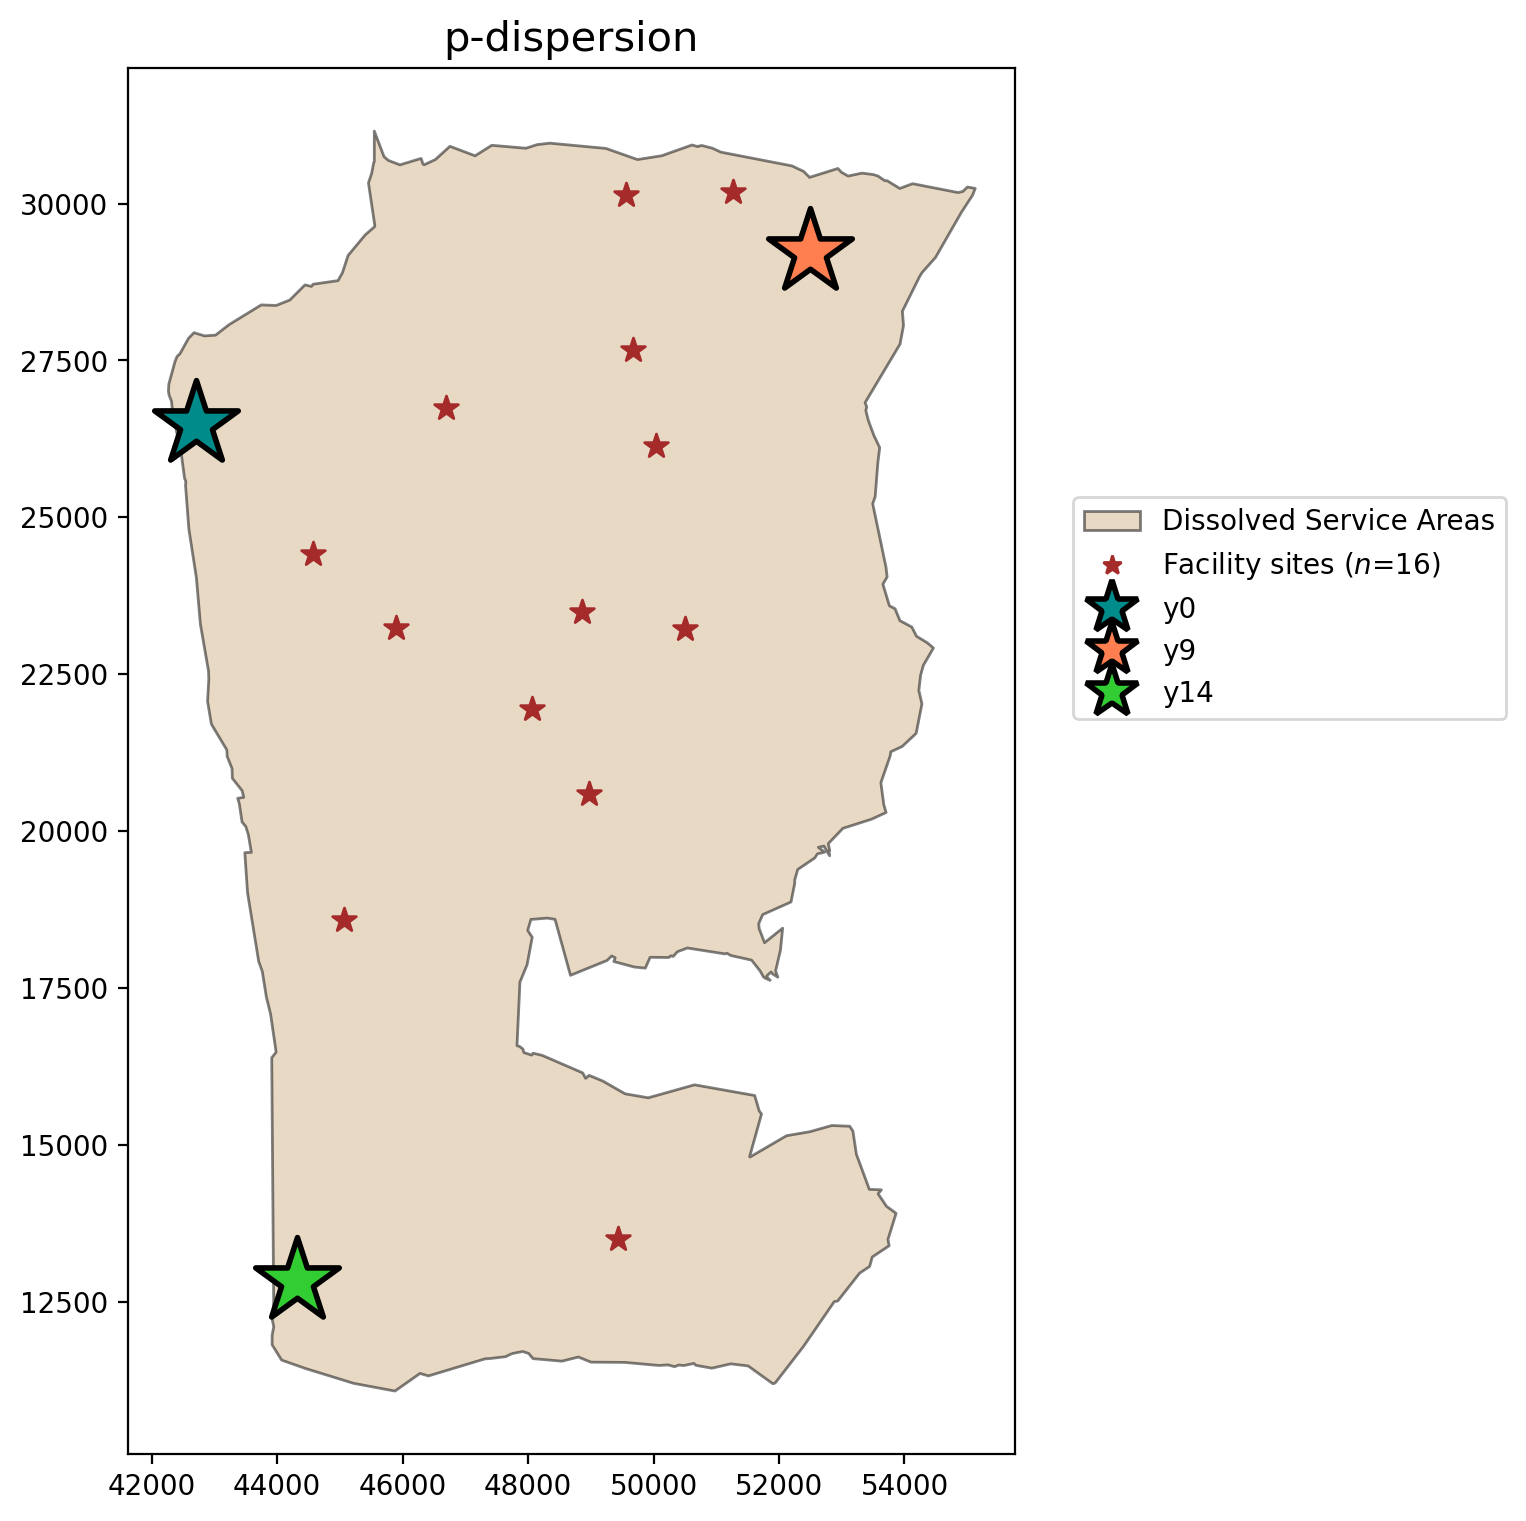

In [20]:
plot_results(pdispersion, P_FACILITIES, facility_points)

## P-Dispersion with selection of predefined candidate facilities

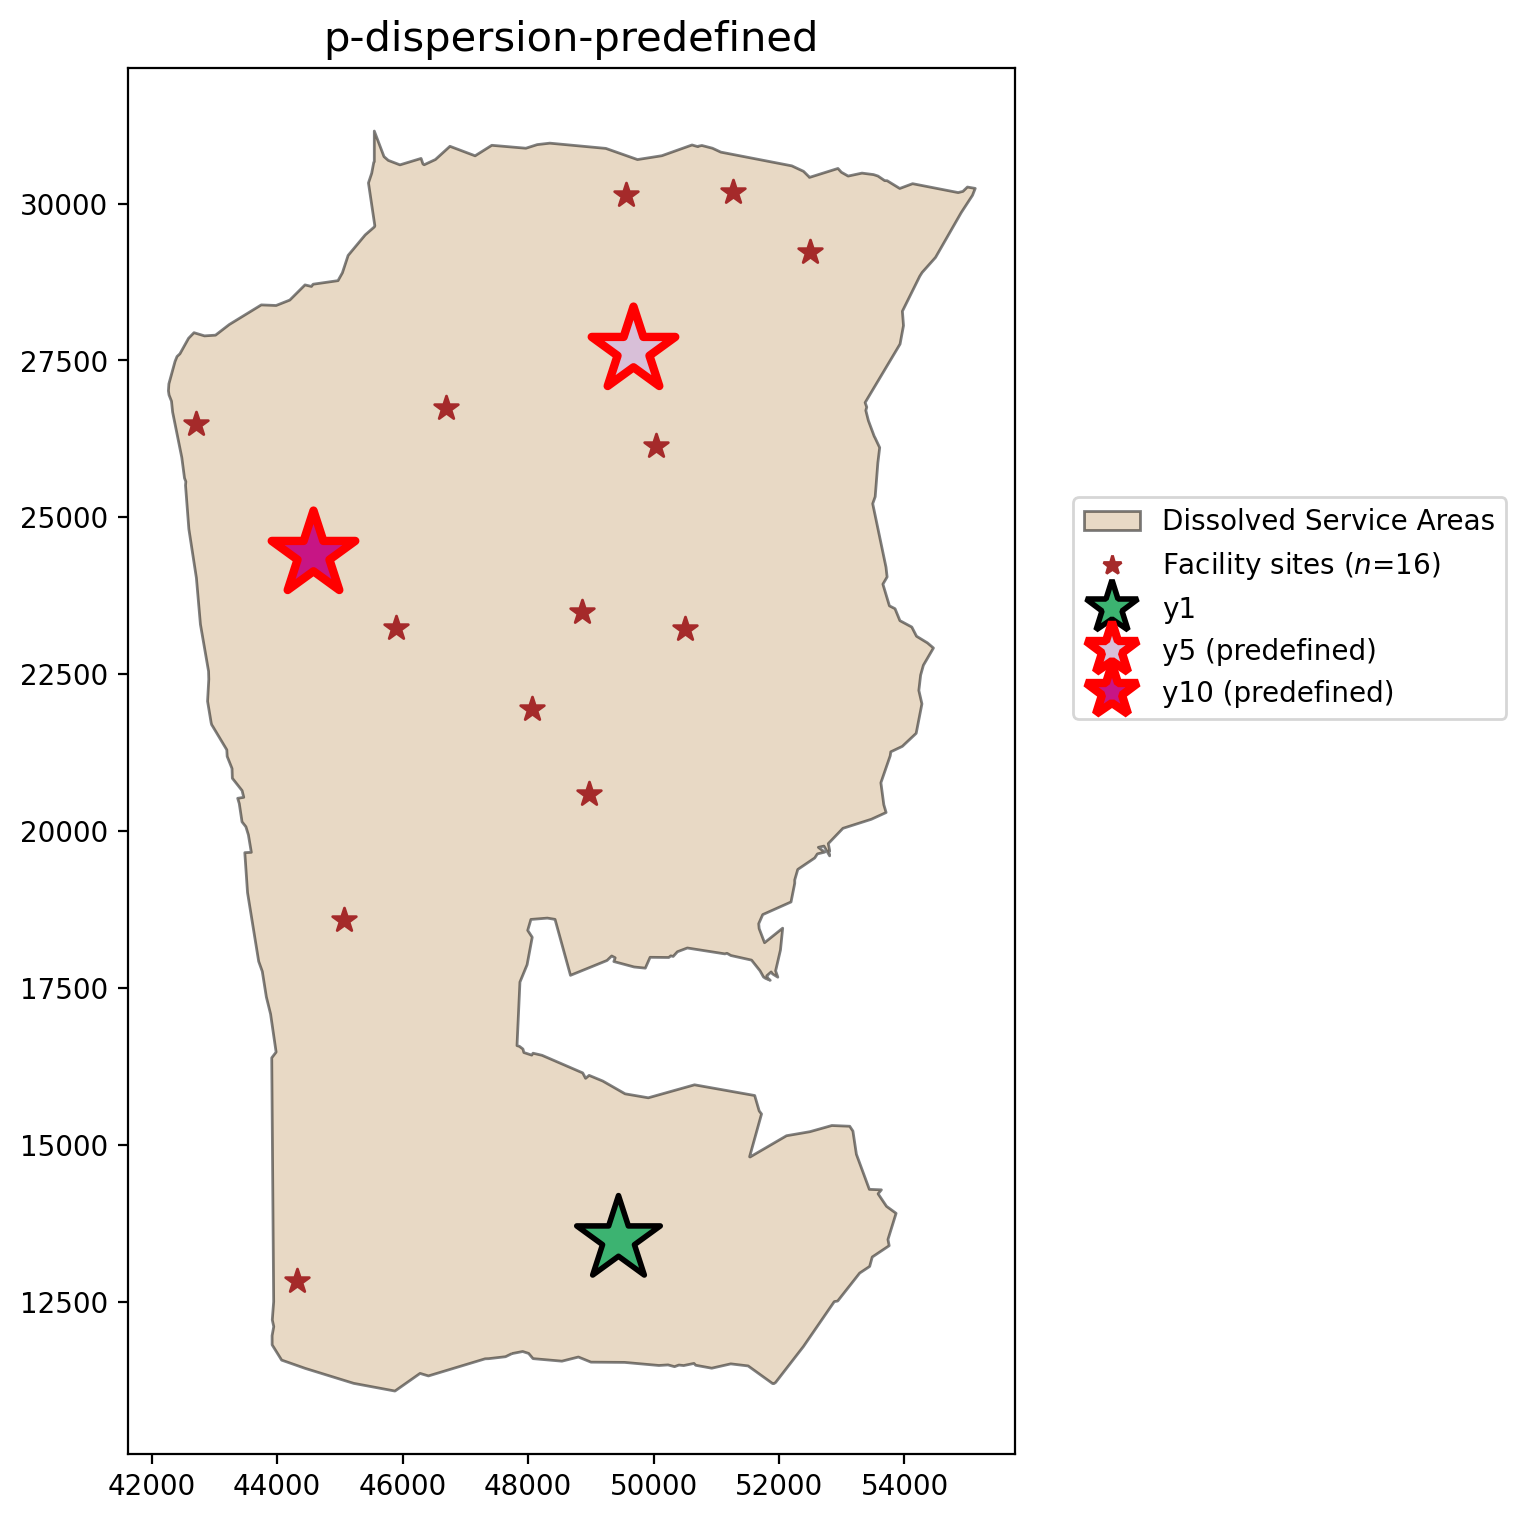

In [21]:
plot_results(pdispersion_pre, P_FACILITIES, facility_points)

-----------------------------------

## Comparing all models

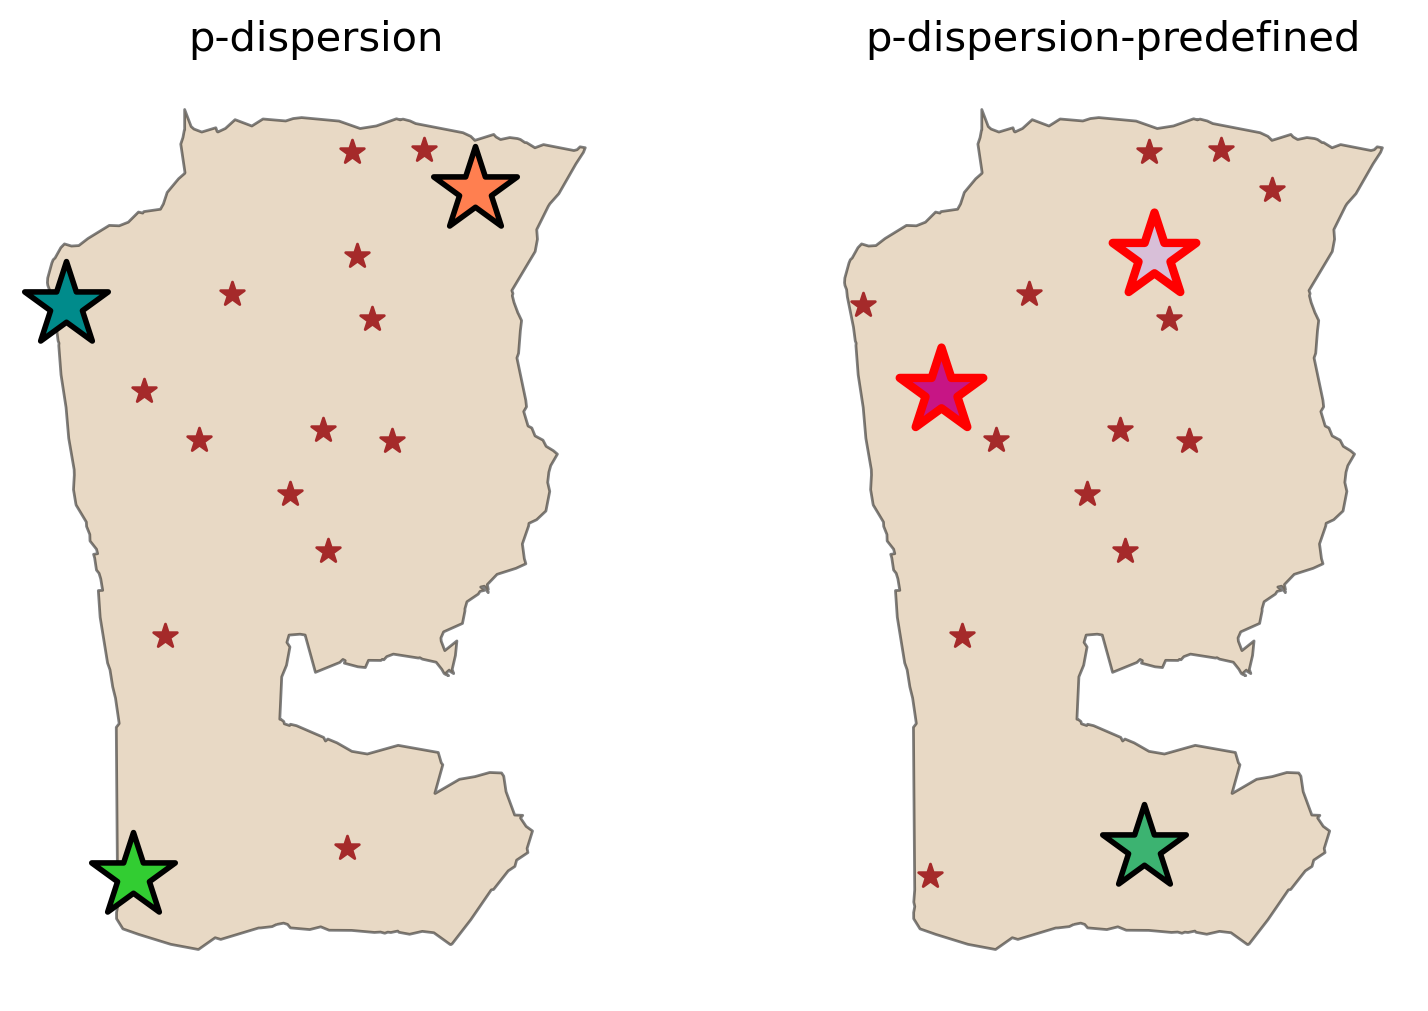

In [22]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=-0.25)
for i, m in enumerate([pdispersion, pdispersion_pre]):
    plot_results(m, P_FACILITIES, facility_points, ax=axarr[i])

When stipulating that $y_{5}$ and $y_{10}$ must be included in the solution a similar triangulated spatial arrangement is observed to satisfy the $p$-dispersion objective: maximizing the interfacilty distance.

----------------------------------------

## Evaluating available solvers

First we'll determine which solvers are installed locally.

In [23]:
with warnings.catch_warnings(record=True) as w:
    solvers = pulp.listSolvers(onlyAvailable=True)
for _w in w:
    print(_w.message)
solvers

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'SCIP_CMD', 'HiGHS', 'HiGHS_CMD']

Above we can see that it returns a list with different solvers that are available. So, it's up to the user to choose the best solver that fits the model. Let's get the percentage as a metric to evaluate which solver is the best or improves the model.

In [24]:
pdispersion = PDispersion.from_geodataframe(
    facility_points,
    "geometry",
    P_FACILITIES,
    distance_metric="euclidean",
)

In [25]:
results = pandas.DataFrame(columns=["MaxMinMin", "Solve Time (sec.)"], index=solvers)
for solver in solvers:
    _solver = pulp.getSolver(solver, msg=False)
    _pdispersion = pdispersion.solve(_solver)
    results.loc[solver] = [
        _pdispersion.problem.objective.value(),
        _pdispersion.problem.solutionTime,
    ]
results

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 121 rows; 17 cols; 376 nonzeros; 16 integer variables (16 binary)
Coefficient ranges:
  Matrix [1e+00, 2e+04]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [3e+00, 6e+04]
Presolving model
121 rows, 17 cols, 376 nonzeros  0s
121 rows, 17 cols, 376 nonzeros  0s

Solving MIP model with:
   121 rows
   17 cols (16 binary, 0 integer, 0 implied int., 1 continuous)
   376 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point; X => User solution

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InL

,MaxMinMin,Solve Time (sec.)
GLPK_CMD,10164.5,0.016731
PULP_CBC_CMD,10164.495,0.048067
COIN_CMD,10164.495,0.055785
SCIP_CMD,10164.494501,0.178769
HiGHS,10164.494501,0.019386
HiGHS_CMD,10164.494501,0.038827


----------------